# This notebook shows the computation of domain coverage

In [1]:
import os
import time
import torch
import random
import heapq
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from contextlib import contextmanager
from pprint import pprint as pp
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from datasets import load_dataset, concatenate_datasets, load_from_disk, Dataset
import pandas as pd
from FlagEmbedding import FlagModel
from sentence_transformers import SentenceTransformer
from sklearn.cluster import MiniBatchKMeans, KMeans

In [2]:
code_data = load_dataset("sahil2801/CodeAlpaca-20k")["train"]
fin_data = load_dataset("FinGPT/fingpt-sentiment-train")["train"]
med_data = load_dataset("medalpaca/medical_meadow_medical_flashcards")["train"]
general_data = load_dataset("tatsu-lab/alpaca")["train"]
math_data = load_dataset("TIGER-Lab/MathInstruct")["train"]

def alpaca_format(example):
    if example['input'] == "":
        example["instruction"] = example["instruction"]
    else:
        example["instruction"] = example["instruction"] + " " + example['input']
    example["response"] = example['output']
    return example

def process_sft_dataset(dataset_name, dataset, dataset_sample=None) -> Dataset:
    if dataset_name in ["lucasmccabe-lmi/CodeAlpaca-20k", "yahma/alpaca-cleaned", "FinGPT/fingpt-sentiment-train"]:
        dataset = dataset.map(alpaca_format, remove_columns=['input', 'output'], desc=f"Preprocessing {dataset_name} for unified format.")
    elif dataset_name in ["WizardLM/WizardLM_evol_instruct_70k"]:
        dataset = dataset.rename_column("output", "response")
    elif dataset_name in ["tatsu-lab/alpaca", "vicgalle/alpaca-gpt4", "gbharti/finance-alpaca"]:
        dataset = dataset.map(alpaca_format, remove_columns=['input', 'output', 'text'], desc=f"Preprocessing {dataset_name} for unified format.")
    elif dataset_name in ["TIGER-Lab/MathInstruct"]:
        df = pd.DataFrame(dataset)
        df = df.drop_duplicates(subset=['instruction'])
        dataset = Dataset.from_pandas(df)
        dataset = dataset.rename_column("output", "response")
        dataset = dataset.remove_columns(['source'])
    elif dataset_name in ["lighteval/MATH"]:
        dataset = dataset.rename_column("solution", "response")
        dataset = dataset.rename_column("problem", "instruction")
        dataset = dataset.remove_columns(['level', 'type'])
    elif dataset_name in ['gsm8k']:
        dataset = dataset.rename_column("question", "instruction")
        dataset = dataset.rename_column("answer", "response")
    elif dataset_name in ['medalpaca/medical_meadow_medical_flashcards']: 
        dataset = dataset.remove_columns(['instruction'])
        dataset = dataset.rename_column("input", "instruction")
        dataset = dataset.rename_column("output", "response")
    elif "math" in dataset_name:
        dataset = dataset.remove_columns(['source'])
        dataset = dataset.rename_column("output", "response")
    else:
        raise NotImplementedError(f"Dataset {dataset_name} is not supported.")
    dataset = dataset.shuffle(seed=42)
    if dataset_sample:
        num_sample = min(len(dataset), dataset_sample)
        dataset = dataset.select(range(num_sample))
    print(f">> ===== After processing, Dataset {dataset_name} has {len(dataset)} examples. =====")
    return dataset

processed_data = []
for name, dataset in zip(["lucasmccabe-lmi/CodeAlpaca-20k","FinGPT/fingpt-sentiment-train","medalpaca/medical_meadow_medical_flashcards","tatsu-lab/alpaca","TIGER-Lab/MathInstruct"],[code_data,fin_data,med_data,general_data,math_data]):
    tmp = process_sft_dataset(name,dataset)
    processed_data.append(tmp)
    
public_data = concatenate_datasets(processed_data)

>> ===== After processing, Dataset lucasmccabe-lmi/CodeAlpaca-20k has 20022 examples. =====
>> ===== After processing, Dataset FinGPT/fingpt-sentiment-train has 76772 examples. =====
>> ===== After processing, Dataset medalpaca/medical_meadow_medical_flashcards has 33955 examples. =====
>> ===== After processing, Dataset tatsu-lab/alpaca has 52002 examples. =====
>> ===== After processing, Dataset TIGER-Lab/MathInstruct has 224567 examples. =====


In [3]:
model = FlagModel('BAAI/bge-large-en-v1.5', 
                  query_instruction_for_retrieval="",
                  use_fp16=True)

In [7]:
method_datasets = [processed_data[0].shuffle(seed=24).select(range(10000))]
root1 = "/mnt/bn/data-tns-live-llm/leon/datasets/fed_data"
root2 = "/mnt/bn/merlin-datavolume-tsy/leon/datasets/fed"

# for name in ["greedy_code_5000"]:
for name in ["random","pos","greedy_code_5000"]:
# for name in ["random_math","pos_math","iid2niid_math_filter"]:
# for name in ["random","pos","iid2niid_code_filter"]:
# for name in ["random_fin","pos_fin","iid2niid_fin_filter"]:
# for name in ["random_med","pos_med","iid2niid_med"]:
    client_pos_datasets = []
    if "greedy" in name: root = root2
    else: root = root1
    
    for i in range(10):
        client_pos_datasets.append(load_from_disk(f"{root}/{name}_{i}.parquet"))
    
    # if "iid2niid" in name:
    #     client_pos_datasets.append(load_from_disk(f"/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/pos_math_{i}.parquet"))

    method_datasets.append(concatenate_datasets(client_pos_datasets).shuffle().select(range(5000)))

import umap
embeddings = []
labels = []
for i, data in enumerate(method_datasets):
    embedding = model.encode(data["instruction"])
    embeddings.extend(embedding)
    labels.extend([i]*len(embedding))

Inference Embeddings: 100%|██████████| 20/20 [00:01<00:00, 17.26it/s]


In [8]:
import numpy as np
# from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt

# 假设 embeddings 和 labels 已经定义好
embeddings = np.array(embeddings)
labels = np.array(labels)

# 使用 TSNE 替代 UMAP
# tsne_model = TSNE(n_components=2, metric='cosine')
tsne_model = TSNE(n_components=2, metric='cosine', n_jobs=128)
# tsne_model = TSNE(n_components=2, n_jobs=128)
tsne_results = tsne_model.fit_transform(embeddings)

# umap_model = umap.UMAP(n_components=2, metric='cosine')
# tsne_results = umap_model.fit_transform(embeddings)

# 调整子图间距
plt.tight_layout()
# 展示所有子图
# plt.show()

<Figure size 640x480 with 0 Axes>

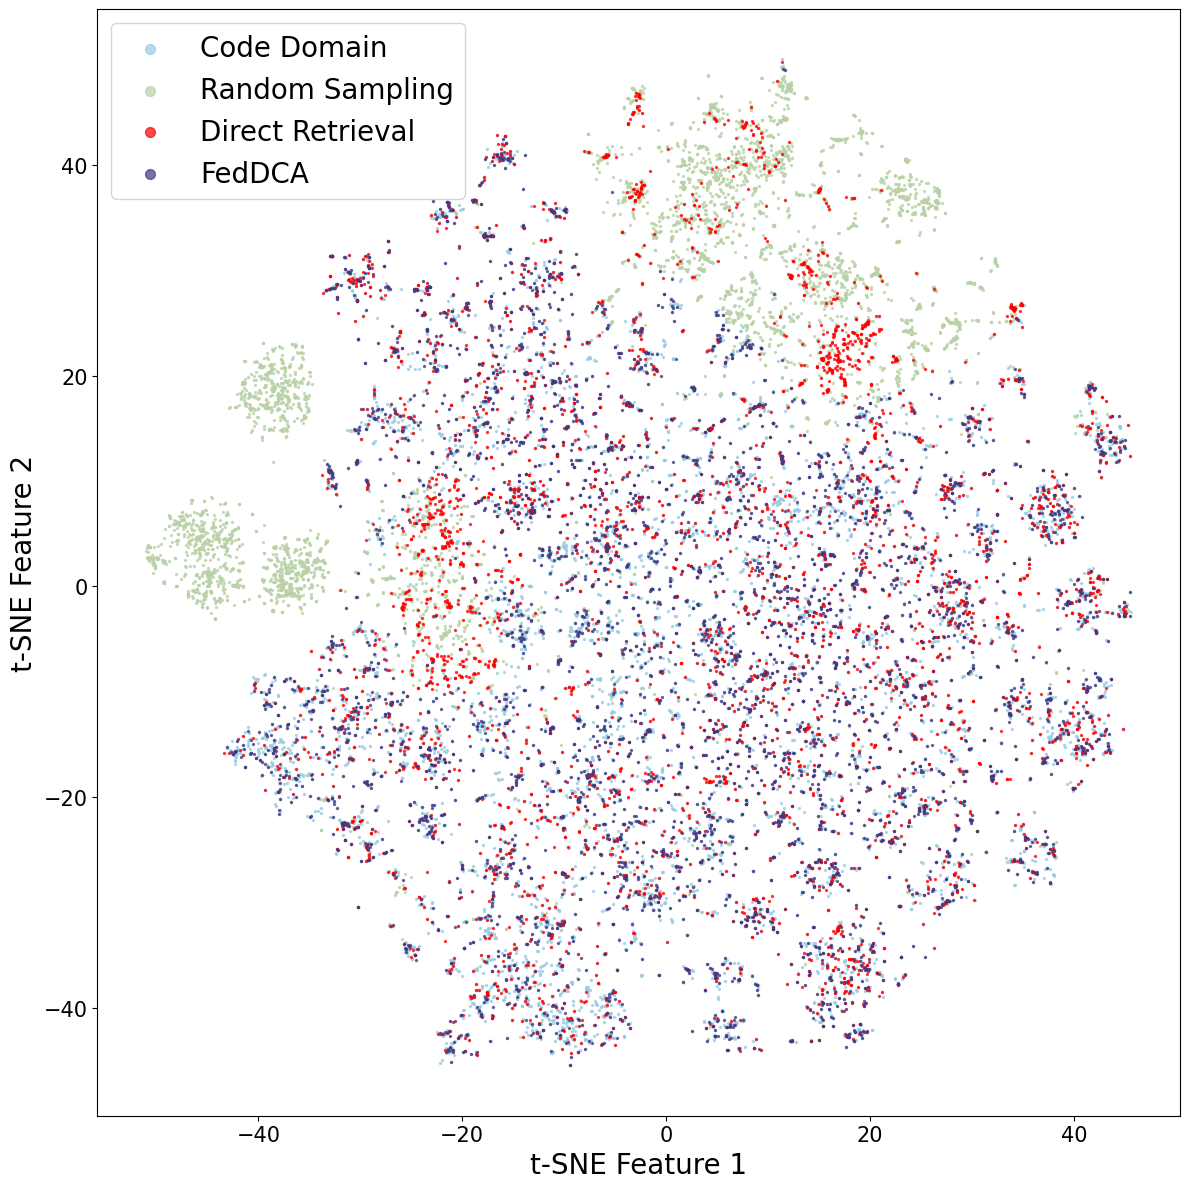

In [9]:
plt.figure(figsize=(12, 12))
colors = ["#96cBE3","#B8D1A7","red","#413982"] 
for i, name in zip(range(len(method_datasets)), ["Code Domain", "Random Sampling", "Direct Retrieval", "FedDCA"]):
# for i, name in zip(range(len(method_datasets)), ["Code Domain", "FedDCA"]):
    # 选择属于当前簇的点
    points = tsne_results[labels == i]
    # 绘制这些点，并用不同的颜色进行区分
    plt.scatter(points[:, 0], points[:, 1], label=f'{name}', s=2, alpha=0.7, color=colors[i])

# plt.title('t-SNE visualization of KMeans clustering')
plt.xlabel('t-SNE Feature 1', fontsize=20)
plt.ylabel('t-SNE Feature 2', fontsize=20)
plt.legend(fontsize=20, markerscale=5)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
# plt.savefig("res/sampling_math.png",dpi=600,format="png")
plt.show()